In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from FCN.layers import *
from FCN.transforms import SegmentationPresetTrain, SegmentationPresetEval
from FCN.metrics import *

import time

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Model

The **backbone** and **decoder** can be modified here. DO NOT change the dataset in this notebook.

If you want to **load the pretrained backbone**, set `self.pretrained_backbone` to `True` in line 5.

In [3]:
class ModelConfig(object):
    def __init__(self):
        self.backbone= 'ResNet'  # 'ResNet', 'AlexNet', 'VGGNet'
        self.decoder= '32x'  # '8x', '16x', '32x'
        self.pretrained_backbone= False,
        self.dataset= 'Cityscapes'  # 'VOC' or 'Cityscapes'

        if self.dataset == 'VOC':
            self.num_classes = 21
            self.ignore_index = 255
        elif self.dataset == 'Cityscapes':
            self.num_classes = 19
            self.ignore_index = 255
            
        if self.backbone == 'ResNet':
            self.decoder_c = (512, 256, 128, self.num_classes)
        elif backbone == 'AlexNet':
            self.decoder_c = (256, 192, 64, self.num_classes)
        elif backbone == 'VGGNet':
            self.decoder_c = (512, 512, 256, self.num_classes)
            
    
    def show_config(self):
        print("Backbone: ", self.backbone)
        print("Decoder: ", self.decoder)
        print("Dataset: ", self.dataset)

**Modify the path of pretrained backbone**  here in line 16 (default: `./pretrained_backbone/ResNet`). Set `pretrained = True` in line 7, 9 or 11 to download the pretrained backbone from PyTorch (to cache).

In [4]:
class FCN(nn.Module):
    def __init__(self, config):
        super(FCN, self).__init__()
        
        self._all_backbone = ['ResNet', 'AlexNet', 'VGGNet']
        if config.backbone == 'ResNet':
            self.backbone = ResNetBackbone(pretrained=False)
        elif config.backbone == 'AlexNet':
            self.backbone = AlexNetBackbone(pretrained=False)
        elif config.backbone == 'VGGNet':
            self.backbone = VGGBackbone(pretrained=False)
        else:
            raise ValueError('backbone must be one of ', self._all_backbone)
        
        if config.pretrained_backbone:
            self.backbone.load_state_dict(torch.load('./pretrained_backbone/' + config.backbone))
        
        self._all_decoder = ['8x', '16x', '32x']
        if config.decoder == '8x':
            self.decoder = Decoder8x(*config.decoder_c)
        elif config.decoder == '16x':
            self.decoder = Decoder16x(*config.decoder_c)
        elif config.decoder == '32x':
            self.decoder = Decoder32x(*config.decoder_c)
        else:
            raise ValueError('decoder must be one of ', self._all_decoder)
    
    def forward(self, img_input):
        feature32, feature16, feature8 = self.backbone(img_input)
        return self.decoder(feature32, feature16, feature8)

In [5]:
model_config = ModelConfig()
model_config.show_config()
model = FCN(model_config)

Backbone:  ResNet
Decoder:  32x
Dataset:  Cityscapes


# Visualization

You might run this part after the model has been trained.

In [6]:
CLASSES = ('road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
               'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
               'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
               'bicycle')

PALETTE = [[128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156],
               [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0],
               [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60],
               [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100],
               [0, 80, 100], [0, 0, 230], [119, 11, 32]]

palette = np.array(PALETTE)

**Specify the path of image and label file** (line 3~4) and **load the model** (line 9) for visualization.

In [92]:
from PIL import Image

img_path = r'.\data\Cityscapes\leftImg8bit\train\aachen\aachen_000173_000019_leftImg8bit.png'
label_path = r'.\data\Cityscapes\gtFine\train\aachen\aachen_000173_000019_gtFine_color.png'
img = Image.open(img_path)
label = Image.open(label_path)
img_tensor, label_tensor = SegmentationPresetEval(512)(img, label)

model.load_state_dict(torch.load(r'pretrained_model\FCN_ResNet_32x_pretrained_backbone_Cityscapes', map_location=torch.device('cpu')))

model.eval()

with torch.no_grad():
    label_pred = model(img_tensor.unsqueeze(dim=0)).argmax(dim=1)
    seg = torchvision.transforms.Resize(img.size)(label_pred.transpose(1, 2))[0].numpy()

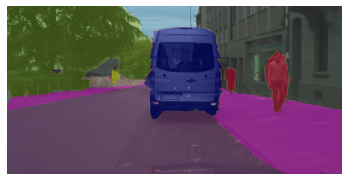

In [93]:
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
for l, color in enumerate(palette):
    color_seg[seg == l, :] = color
    #color_seg = color_seg[..., ::]

plt.imshow(img, alpha=1)
plt.imshow(color_seg.transpose(1, 0, 2), alpha=0.5)
#plt.imshow(label, alpha=0.5)
plt.axis(False)
plt.show()

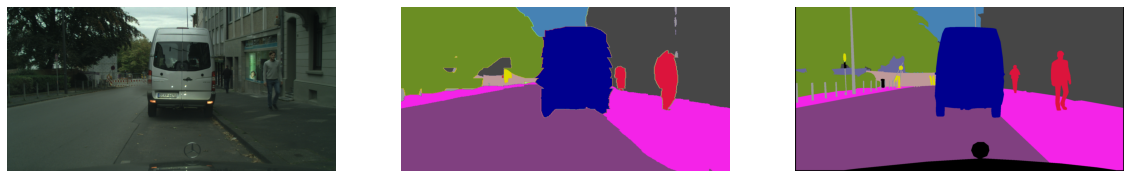

In [9]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis(False)

plt.subplot(1, 3, 2)
plt.imshow(color_seg.transpose(1, 0, 2))
plt.axis(False)

plt.subplot(1, 3, 3)
plt.imshow(label)
plt.axis(False)

plt.show()

# Train 

The **hyper parameters** can be adjusted here. Specifically, you may set the `batch_size` as 16 and manually decrease the learning rate.

In [18]:
class TrainConfig(object):
    def __init__(self):
        self.batch_size = 16
        self.val_batch_size = 32
        self.num_epoches = 1
        self.num_eval_batch = 5
        self.lr = 1e-3
        self.save_path = './pretrained_model/FCN_ResNet_pretrained_backbone'
    
    def show_config(self):
        print("Batch size: ", self.batch_size)
        print("Epoch num: ", self.num_epoches)
        print("Learning rate: ", self.lr)
        print("Validation batch size: ", self.val_batch_size)
        print("Evaluation batch num: ", self.num_eval_batch)

The code below prepares the data, setting `download=True` (line 7 and 13) downloads the data to `./data` (line 4 and 10).

In [20]:
train_config = TrainConfig()
train_config.show_config()

train_dataset = torchvision.datasets.Cityscapes('./data/Cityscapes',
                                                split='train',
                                                mode='fine',
                                                target_type='semantic',
                                                transforms=SegmentationPresetTrain(1024, 512))

val_dataset = torchvision.datasets.Cityscapes('./data/Cityscapes',
                                              split='val',
                                              mode='fine',
                                              target_type='semantic',
                                              transforms=SegmentationPresetEval(512))


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_config.batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=train_config.val_batch_size, shuffle=True)

print("{:d} training images in {:d} batches".format(len(train_dataset), len(train_dataloader)))
print("{:d} validation images in {:d} batches".format(len(val_dataset), len(val_dataloader)))

Batch size:  16
Epoch num:  1
Learning rate:  0.001
Validation batch size:  32
Evaluation batch num:  5


RuntimeError: Dataset not found or incomplete. Please make sure all required folders for the specified "split" and "mode" are inside the "root" directory

In [53]:
model.to(device)

CrossEntropyLoss = nn.CrossEntropyLoss(ignore_index=model_config.ignore_index)
optim = torch.optim.Adam(model.parameters(), lr=train_config.lr)

loss_record = []
val_loss_record = []
acc_record = []
mIoU_record = []

tick =  time.time()

best_mIoU = -1
best_epoch = -1

for epoch in range(train_config.num_epoches):
    print("Epoch: {:3d}".format(epoch + 1))
    tick_e = time.time()
    print("------------------ Training ------------------")
    for step, (X, y) in enumerate(train_dataloader):
        tick_i = time.time()
        
        model.train()
        optim.zero_grad()
        
        pred = model(X.to(device))
        loss = CrossEntropyLoss(pred, y.to(device))
        
        loss.backward()
        optim.step()
        
        loss_record.append(loss.item())

        print("Iteration {:3d} |\tLoss: {:.4f}\tTime:{: .2f}s (Total: {:.2f}s)".format(step,
                                                                                         loss.item(),
                                                                                         time.time() - tick_i,
                                                                                         time.time() - tick))
        
    print("------------------ Evaluation ----------------")
    model.eval()

    tick_eval = time.time()
    val_loss = 0
    total_area_intersect, total_area_union, total_area_pred_label, total_area_label = 0, 0, 0, 0
    
    for step, (X, y) in enumerate(val_dataloader):
        with torch.no_grad():
            pred = model(X.to(device))
            val_loss += CrossEntropyLoss(pred, y.to(device)).item()
            
            label_pred = pred.argmax(dim=1)
            area_intersect, area_union, area_pred_label, area_label = total_intersect_and_union(label_pred.cpu().numpy(),
                                                                                                y.numpy(),
                                                                                                num_classes=model_config.num_classes,
                                                                                                ignore_index=model_config.num_classes)
            total_area_intersect += area_intersect
            total_area_union += area_union
            total_area_pred_label += area_pred_label
            total_area_label += area_label
        if step + 1 == train_config.num_eval_batch:
            break
    
    val_loss /= (step + 1)
    val_loss_record.append(val_loss)
    
    acc = total_area_intersect.sum() / total_area_label.sum()
    mIoU = (total_area_intersect / total_area_union).mean()
    
    acc_record.append(acc)
    mIoU_record.append(mIoU)    
    
    if mIoU > best_mIoU:
        best_mIoU = mIoU
        best_epoch = epoch
        torch.save(model.state_dict(), train_config.save_path)
        
    print("Evaluation completed in {:.2f}s (Epoch: {:.2f}s\tTotal: {:.2f}s)".format(time.time() - tick_eval,
                                                                                    time.time() - tick_e,
                                                                                    time.time() - tick))
    print("Loss = {:.3f}\tPixelwise accuracy = {:.2f}\tmIoU = {:.2f}".format(val_loss, acc, mIoU))
    print("Best mIoU: {:.2f} in epoch {:3d}".format(best_mIoU, best_epoch + 1))
    print("==============================================")

Epoch:   1
------------------ Training ------------------
Iteration   0 |	Loss: 0.1953	Time: 28.36s (Total: 30.97s)
------------------ Evaluation ----------------
Evaluation completed in 26.23s (Epoch: 57.21s	Total: 57.21s)
Loss = 0.727	Pixelwise accuracy = 0.86	mIoU = 0.29
Best mIoU: 0.29 in epoch   1


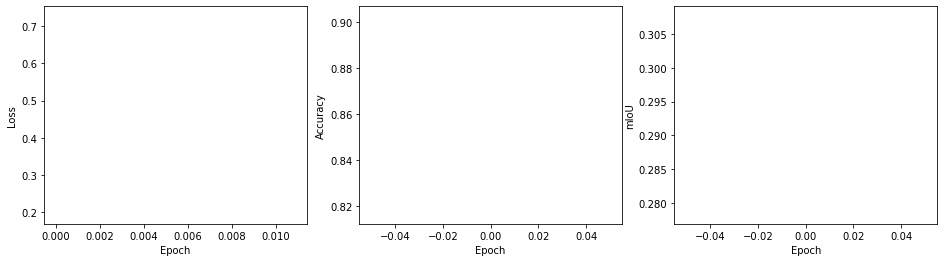

In [54]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(np.arange(1, len(loss_record)+1) / len(train_dataloader), loss_record)
plt.plot(val_loss_record)

#plt.xticks(np.arange(1, 3))
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(acc_record)

#plt.xticks(np.arange(1, num_epoches + 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(mIoU_record)

#plt.xticks(np.arange(1, num_epoches + 1))
plt.xlabel('Epoch')
plt.ylabel('mIoU')

plt.show()

# Evaluating 

Evaluate the model by computing pixelwise accuracy and mIoU over the whole validation dataset

In [56]:
model.eval()

tick_eval = time.time()
total_area_intersect, total_area_union, total_area_pred_label, total_area_label = 0, 0, 0, 0
for step, (X, y) in enumerate(val_dataloader):
    #print(X.shape, y.shape)
    with torch.no_grad():
        label_pred = model(X).argmax(dim=1)
        area_intersect, area_union, area_pred_label, area_label = total_intersect_and_union(label_pred.cpu().numpy(),
                                                                                            y.numpy(),
                                                                                            num_classes=model_config.num_classes,
                                                                                            ignore_index=model_config.num_classes)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label
    if step == 1:
        break
        
acc = total_area_intersect.sum() / total_area_label.sum()
mIoU = (total_area_intersect / total_area_union).mean()
print("Evaluation completed in {:.2f}s".format(time.time() - tick_eval))
print("Pixelwise accuracy = {:.2f}\tmIoU = {:.2f}".format(acc, mIoU))

Evaluation completed in 42.92s
Pixelwise accuracy = 0.77	mIoU = 0.26


# Save

FileNotFoundError: [Errno 2] No such file or directory: './data/Cityscapes/colors\\aachen_000173_000019.pngimg'

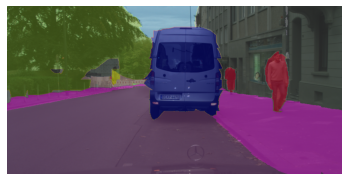

In [151]:
test_img_path = []
for root, dirnames, file in os.walk(r'./data/Cityscapes/leftImg8bit'):
    for f in file:
        test_img_path.append(os.path.join(root, f))
print("{:d} evaluation images".format(len(test_img_path)))
        
model.eval()
for i in range(len(test_img_path)):
    img_path = test_img_path[i]
    print("({:3d}/{:d}) Processing {:s}".format(i+1, len(test_img_path)+1, img_path))
    sys.stdout.flush()
    
    img = Image.open(img_path)
    img_tensor, _ = SegmentationPresetEval(512)(img, img)
    with torch.no_grad():
        label_pred = model(img_tensor.to(device).unsqueeze(dim=0)).argmax(dim=1)
        label_pred = label_pred.transpose(1, 2)[0].detach().cpu().numpy().astype(np.uint8)

        seg = np.array(torchvision.transforms.Resize(img.size)(torchvision.transforms.ToPILImage()(label_pred)))
        
        result = np.ones_like(seg).astype(np.uint8)
        for key, value in trainId2label.items():
            result[seg == key] = value.id
        
        color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
        for l, color in enumerate(palette):
            color_seg[seg == l, :] = color
        
        img_name = img_path.split('/')[-1].split('\\')[-1]
        Image.fromarray(result.T).save(os.path.join(r'./data/Cityscapes/results', img_name.replace('_leftImg8bit', '')))
        Image.fromarray(color_seg.transpose(1, 0, 2)).save(os.path.join(r'./data/Cityscapes/colors', img_name.replace('_leftImg8bit', '')))

1 evaluation images
(  1/2) Processing ./data/Cityscapes/leftImg8bit\train\aachen\aachen_000173_000019_leftImg8bit.png


FileNotFoundError: [Errno 2] No such file or directory: './data/Cityscapes/colors\\aachen_000173_000019.png'

# Analyze json result

In [131]:
import json

In [136]:
f = open('resultPixelLevelSemanticLabeling.json')
d = json.load(f)
f.close()
